<a href="https://colab.research.google.com/github/petroDavydov/goit-DeepLearningForComputerVisionAndNLP/blob/main/convolutional_neural_networks_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Convolution Neural Networks***
### Згорткові нейронні мережі

In [ ]:
!pip install opencv-python


In [ ]:
import os
import random
from collections import defaultdict
from tqdm.autonotebook import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import cv2
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn.functional as F

from sklearn.metrics import balanced_accuracy_score

import warnings
# filter warnings
warnings.filterwarnings('ignore')

/tmp/ipython-input-3081382395.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Приклад матриці, зображення 3х3 у відтінках сірого:

\begin{bmatrix}
0 & 128 & 255 \\
64 & 192 & 32 \\
255 & 128 & 0
\end{bmatrix}







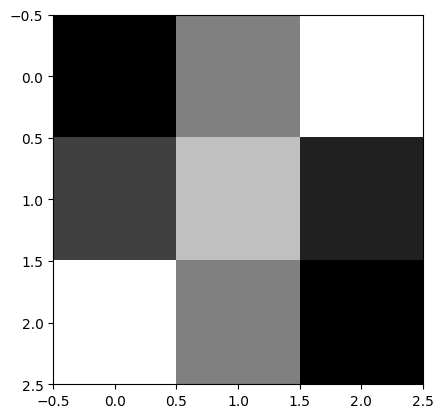

In [ ]:
data =[[0,128,255], [64,192,32], [255,128,0]]
plt.imshow(data, cmap='gray')
plt.show()

Приклад матриці, зображення 2х2 у колорова матриця:


Червоний колір:

\begin{bmatrix}
255 & 0 \\
128 & 64
\end{bmatrix}



Зелений колір:

\begin{bmatrix}
128 & 255 \\
64 & 0
\end{bmatrix}


Синій колір:

\begin{bmatrix}
0 & 128 \\
255 & 192
\end{bmatrix}


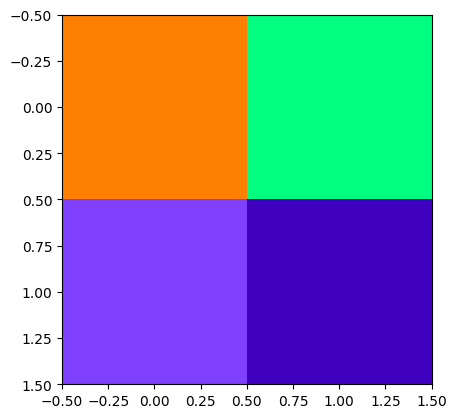

In [ ]:
data = [[[255, 0], [128, 64]], [[128, 255], [64, 0]], [[0, 128], [255, 192]]]
data = np.moveaxis(data, 0, -1)
plt.imshow(data)
plt.show()


# Вирішуємо задачу багатокласової класифікації зображень

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/DeepLearningforComputervisionandNLP/SIGNS_dataset'
splits =['train','test']

# # Display images examples

1080 images in train
Number of examples for class 0: 180


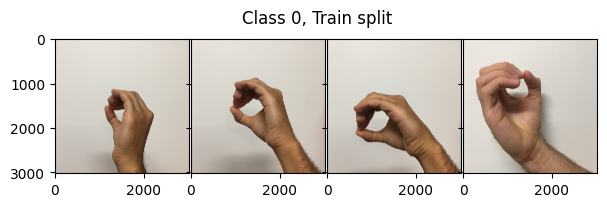

Number of examples for class 1: 180


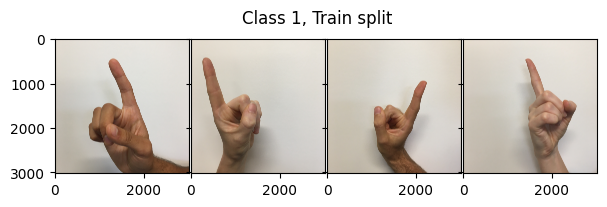

Number of examples for class 2: 180


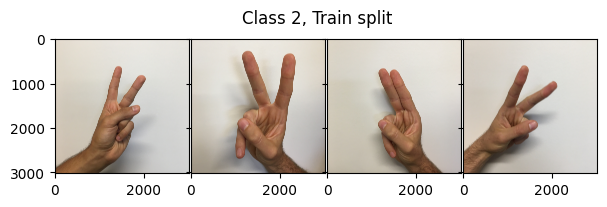

Number of examples for class 3: 180


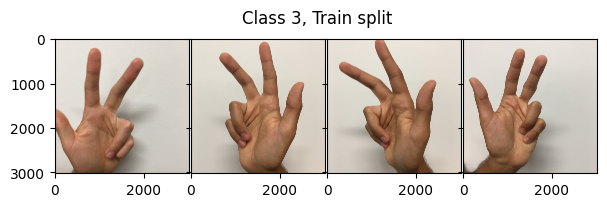

Number of examples for class 4: 180


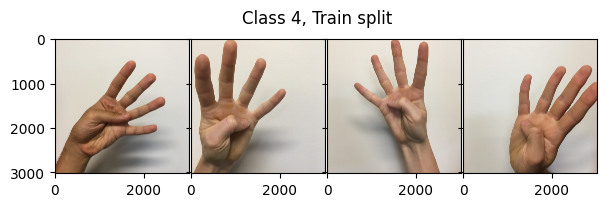

Number of examples for class 5: 180


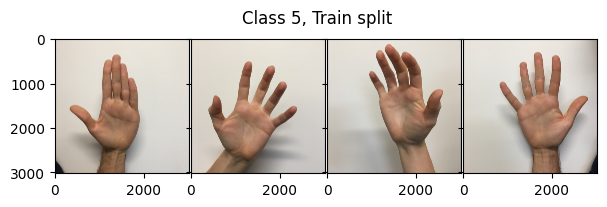

120 images in test
Number of examples for class 0: 20
Number of examples for class 1: 20
Number of examples for class 2: 20
Number of examples for class 3: 20
Number of examples for class 4: 20
Number of examples for class 5: 20


In [ ]:
# iterate over train and test folders
for s in splits:
		# list files in the folder with the jpg extension
  files = [f for f in os.listdir(f"{data_path}/{s}_signs") if f.endswith('.jpg')]
  print(f'{len(files)} images in {s}')

  # for each image, create a list of the type [class, filename]
  files = [f.split('_', 1) for f in files]

  # group the data by class
  files_by_sign = defaultdict(list)
  for k, v in files:
    files_by_sign[k].append(v)

  # take random 4 images of each class
  for k, v in sorted(files_by_sign.items()):
    print(f'Number of examples for class {k}:', len(v))

    # display several examples of images from the training sample
    if s == 'train':
      random.seed(42)

      imgs_path = random.sample(v, 4)
      imgs_path = [os.path.join(data_path, f'{s}_signs/{k}_{p}') for p in imgs_path]

      # read the image using the opencv library
      imgs = [cv2.imread(p) for p in imgs_path]
      # matplotlib expects img in RGB format but OpenCV provides it in BGR
      # transform the BGR image into RGB
      imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]

      # create a figure for display
      fig = plt.figure(figsize=(7, 2))
      grid = ImageGrid(
        fig, 111,
        nrows_ncols=(1, 4)
      )
      # display the image
      for ax, img in zip(grid, imgs):
        ax.imshow(img)

      fig.suptitle(f'Class {k}, {s.capitalize()} split')
      plt.show()

In [ ]:
img.shape

(3024, 3024, 3)

In [ ]:
input = torch.randn(20, 16, 50, 100) # batch_size, in_channels, h, w


In [ ]:
# pool of square window of kernel_size=3, stride=2
m = nn.MaxPool2d(3, stride=2)
output = m(input)
output.shape


torch.Size([20, 16, 24, 49])

In [ ]:
# pool of non-square window
m = nn.MaxPool2d((3, 2), stride=(2, 1))
output = m(input)
output.shape


torch.Size([20, 16, 24, 99])

# Augmentation

In [ ]:
%matplotlib inline
orig_img = Image.fromarray(img)

In [ ]:
def plot_examples(transformed_imgs:list, col_titles:list, cmap=None):

    n_cols = len(transformed_imgs) +1
    fig_size_x = 3 + len(transformed_imgs) * 1.5
    fig, axs = plt.subplots(1, n_cols, figsize=(fig_size_x,2))

    axs[0].imshow(orig_img)
    axs[0].set_title('original image')

    for i in range(len(transformed_imgs)):
        axs[i+1].imshow(transformed_imgs[i], cmap=cmap)
        axs[i+1].set_title(col_titles[i])

    plt.tight_layout()
    plt.show()


### resize

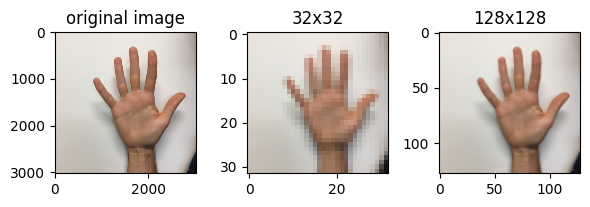

In [ ]:
resized_imgs = [T.Resize(size=size)(orig_img) for size in [32,128]]
plot_examples(resized_imgs, ['32x32', '128x128'])


### Gray Scale

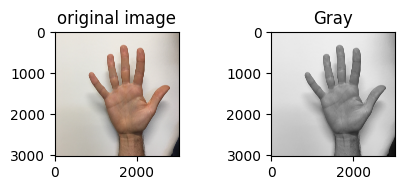

In [ ]:
gray_img = T.Grayscale()(orig_img)
plot_examples([gray_img], ["Gray"], 'gray')


### Normalize

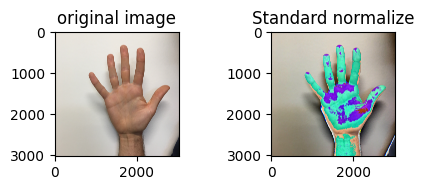

In [ ]:
normalized_img = T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))(T.ToTensor()(orig_img))
normalized_img = [T.ToPILImage()(normalized_img)]
plot_examples(normalized_img, ["Standard normalize"])


### Random Rotation



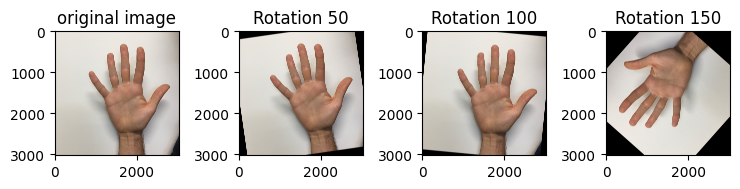

In [ ]:
rotated_imgs = [T.RandomRotation(degrees=d)(orig_img) for d in range(50,151,50)]
plot_examples(rotated_imgs, ["Rotation 50","Rotation 100","Rotation 150"])


### Center Crop



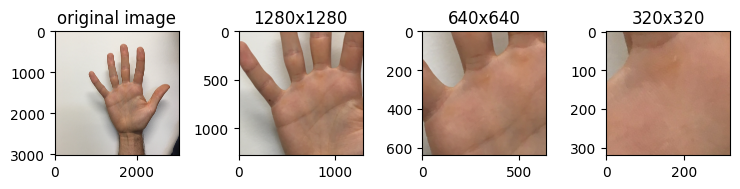

In [ ]:
center_crops = [T.CenterCrop(size=size)(orig_img) for size in (1280,640, 320)]
plot_examples(center_crops,['1280x1280','640x640','320x320'])


### Random Crop



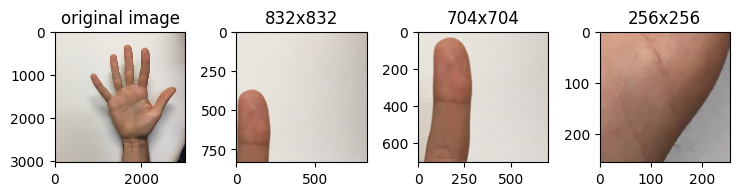

In [ ]:
random_crops = [T.RandomCrop(size=size)(orig_img) for size in (832,704, 256)]
plot_examples(random_crops,['832x832','704x704','256x256'])


### Gaussian Blur



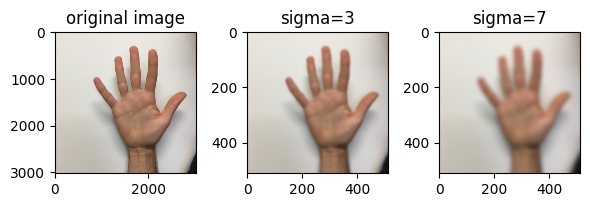

In [ ]:
downsized_img = T.Resize(size=512)(orig_img)
blurred_imgs = [T.GaussianBlur(kernel_size=(51, 91), sigma=sigma)(downsized_img) for sigma in (3,7)]
plot_examples(blurred_imgs, ['sigma=3', 'sigma=7'])


### Gaussian Noise



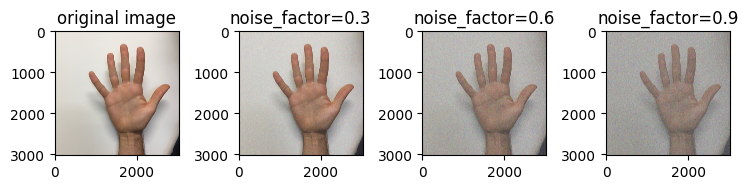

In [ ]:
def add_noise(inputs,noise_factor=0.3):
    noisy = inputs+torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy,0.,1.)
    return noisy

noise_imgs = [add_noise(T.ToTensor()(orig_img),noise_factor) for noise_factor in (0.3,0.6,0.9)]
noise_imgs = [T.ToPILImage()(noise_img) for noise_img in noise_imgs]
plot_examples(noise_imgs, ["noise_factor=0.3","noise_factor=0.6","noise_factor=0.9"])


### Random Blocks



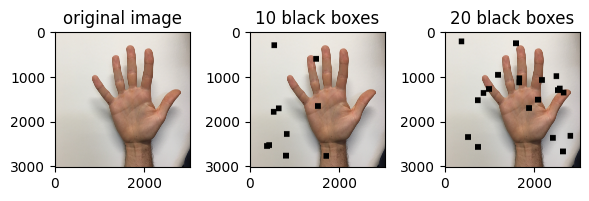

In [ ]:
def add_random_boxes(img,n_k,size=32):
    h,w = size,size
    img = np.asarray(img).copy()
    img_size = img.shape[1]
    boxes = []
    for k in range(n_k):
        y,x = np.random.randint(0,img_size-w,(2,))
        img[y:y+h,x:x+w] = 0
        boxes.append((x,y,h,w))
    img = Image.fromarray(img.astype('uint8'), 'RGB')
    return img

blocks_imgs = [add_random_boxes(orig_img,n_k=i, size=128) for i in (10,20)]
plot_examples(blocks_imgs, ["10 black boxes","20 black boxes"])


### -----------------------------------

# Batch Normalization


In [ ]:
# With Learnable Parameters
m = nn.BatchNorm1d(5) # num_features
input = torch.randn(4, 5)
# Without Learnable Parameters
m = nn.BatchNorm1d(5, affine=False) # learnable parameters γ and β

output = m(input)

print('Input:\n', input, '\n\n', f'mean {input.mean()}, std {input.std()}', '\n')
print('Output:\n', input, '\n\n', f'mean {output.mean()}, std {output.std()}', '\n')

Input:
 tensor([[ 1.8790e+00, -4.3046e-01, -1.9673e-01,  1.2218e+00, -1.0640e+00],
        [ 3.6850e-01, -9.8668e-04, -2.4298e-01,  2.0876e+00,  1.4062e-01],
        [ 3.1079e-01,  1.1209e+00, -1.5524e+00,  4.9898e-01, -2.6475e-02],
        [-1.6054e+00,  2.3899e+00, -9.9378e-01, -1.0330e+00,  9.3637e-01]]) 

 mean 0.1904095709323883, std 1.1575877666473389 

Output:
 tensor([[ 1.8790e+00, -4.3046e-01, -1.9673e-01,  1.2218e+00, -1.0640e+00],
        [ 3.6850e-01, -9.8668e-04, -2.4298e-01,  2.0876e+00,  1.4062e-01],
        [ 3.1079e-01,  1.1209e+00, -1.5524e+00,  4.9898e-01, -2.6475e-02],
        [-1.6054e+00,  2.3899e+00, -9.9378e-01, -1.0330e+00,  9.3637e-01]]) 

 mean 1.7881394143159923e-08, std 1.025970697402954 



In [ ]:
class SIGNSDataset(Dataset):
    def __init__(self, data_dir, transform):
        #store filenames
        self.filenames = os.listdir(data_dir)
        self.filenames = [os.path.join(data_dir, f) for f in self.filenames if f.endswith('.jpg')]
        #the first character of the filename contains the label
        self.labels = [int(filename.split('/')[-1][0]) for filename in self.filenames]
        self.transform = transform

    def __len__(self):
        #return size of dataset
        return len(self.filenames)

    def __getitem__(self, idx):
        #open image, apply transforms and return with label
        image = Image.open(self.filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [ ]:
train_transformer = T.Compose([
    T.Resize(64),              # resize the image to 64x64
    T.RandomHorizontalFlip(),  # randomly flip image horizontally
    T.ToTensor()])             # transform it into a PyTorch Tensor

test_transformer = T.Compose([
    T.Resize(64),
    T.ToTensor()])

In [ ]:
train_dataset = SIGNSDataset(f'{data_path}/train_signs/', train_transformer)
test_dataset = SIGNSDataset(f'{data_path}/test_signs/', test_transformer)

In [ ]:
class BaselineModel(nn.Module):

    def __init__(self, ):
        super().__init__()
        self.num_channels = 32

        # each of the convolution layers below have the arguments (input_channels, output_channels, filter_size,
        # stride, padding). We also include batch normalisation layers that help stabilise training.

        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)

        # 2 fully connected layers to transform the output of the convolution layers to the final output
        self.fc1 = nn.Linear(8*8*self.num_channels*4, self.num_channels*4)
        self.fc2 = nn.Linear(self.num_channels*4, 6)

    def forward(self, s):
        #                                                  -> batch_size x 3 x 64 x 64
        # we apply the convolution layers, followed by batch normalisation, maxpool and relu x 3
        s = self.conv1(s)                                   # batch_size x num_channels x 64 x 64
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels x 32 x 32
        s = self.conv2(s)                                   # batch_size x num_channels*2 x 32 x 32
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels*2 x 16 x 16
        s = self.conv3(s)                                   # batch_size x num_channels*4 x 16 x 16
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels*4 x 8 x 8

        # flatten the output for each image
        s = s.view(-1, 8*8*self.num_channels*4)             # batch_size x 8*8*num_channels*4

        # apply 2 fully connected layers with dropout
        s = F.relu(self.fc1(s))                             # batch_size x self.num_channels*4
        s = self.fc2(s)                                     # batch_size x 6

        # apply log softmax on each image's output (this is recommended over applying softmax
        # since it is numerically more stable)
        return F.log_softmax(s, dim=1)

In [ ]:
cuda = torch.cuda.is_available()

# Set the random seed for reproducible experiments
torch.manual_seed(42)
if cuda:
    torch.cuda.manual_seed(42)

# Specify a computing device
device = 'cuda' if cuda else 'cpu'

In [ ]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=32,
                              shuffle=True,
                              num_workers=4)

test_dataloader = DataLoader(test_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=1)

In [ ]:
# Define the model and optimizer
model = BaselineModel().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss().to(device)

# Train the model

train_losses = []
train_accs = []

test_losses = []
test_accs = []

num_epochs = 15

for epoch in tqdm(range(num_epochs)):

    # Train step

    model.train()

    train_epoch_loss = []
    train_epoch_acc = []

    for i, (train_batch, labels_batch) in tqdm(enumerate(train_dataloader)):
        if cuda:
            train_batch, labels_batch = train_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)

        # compute model output and loss
        output_batch = model(train_batch)

        loss = criterion(output_batch, labels_batch)

        # clear previous gradients, compute gradients of all variables wrt loss
        optimizer.zero_grad()
        loss.backward()

        # performs updates using calculated gradients
        optimizer.step()

        batch_loss = loss.cpu().detach().numpy()
        batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                                            labels_batch.cpu().detach().numpy())

        train_epoch_loss.append(batch_loss)
        train_epoch_acc.append(batch_acc)


    print(f'Train epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(train_epoch_loss):.4f}, Acc: {np.mean(train_epoch_acc)}')
    train_accs.append(np.mean(train_epoch_acc))
    train_losses.append(np.mean(train_epoch_loss))

    # Eval step

    model.eval()

    test_epoch_loss = []
    test_epoch_acc = []

    with torch.no_grad():

        for i, (test_batch, labels_batch) in enumerate(test_dataloader):
            if cuda:
                test_batch, labels_batch = test_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)

            # compute model output and loss
            output_batch = model(test_batch)

            loss = criterion(output_batch, labels_batch)

            batch_loss = loss.cpu().detach().numpy()
            batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                                                labels_batch.cpu().detach().numpy())

            test_epoch_loss.append(batch_loss)
            test_epoch_acc.append(batch_acc)
    print(f'Test epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(test_epoch_loss):.4f}, Acc: {np.mean(test_epoch_acc)}')
    test_accs.append(np.mean(test_epoch_acc))
    test_losses.append(np.mean(test_epoch_loss))

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train epoch [1/15], Loss: 1.7895, Acc: 0.25909936927642285
Test epoch [1/15], Loss: 1.7644, Acc: 0.4458333333333333


0it [00:00, ?it/s]

Train epoch [2/15], Loss: 1.5840, Acc: 0.4042112869418374
Test epoch [2/15], Loss: 1.4009, Acc: 0.46079094516594515


0it [00:00, ?it/s]

Train epoch [3/15], Loss: 1.2389, Acc: 0.5777593158475511
Test epoch [3/15], Loss: 1.1843, Acc: 0.5066603535353535


0it [00:00, ?it/s]

Train epoch [4/15], Loss: 1.0588, Acc: 0.6521664637105814
Test epoch [4/15], Loss: 1.0390, Acc: 0.5559485653235653


0it [00:00, ?it/s]

Train epoch [5/15], Loss: 0.8971, Acc: 0.7271411839794192
Test epoch [5/15], Loss: 0.8746, Acc: 0.6747285353535354


0it [00:00, ?it/s]

Train epoch [6/15], Loss: 0.7417, Acc: 0.7585204283733695
Test epoch [6/15], Loss: 0.6899, Acc: 0.6899299719887956


0it [00:00, ?it/s]

Train epoch [7/15], Loss: 0.5758, Acc: 0.8152066887361006
Test epoch [7/15], Loss: 0.5911, Acc: 0.6731025945731828


0it [00:00, ?it/s]

Train epoch [8/15], Loss: 0.5346, Acc: 0.8201127168038933
Test epoch [8/15], Loss: 0.5607, Acc: 0.7487333152958153


0it [00:00, ?it/s]

Train epoch [9/15], Loss: 0.4479, Acc: 0.8589655306567071
Test epoch [9/15], Loss: 0.5007, Acc: 0.7315277777777778


0it [00:00, ?it/s]

Train epoch [10/15], Loss: 0.3717, Acc: 0.8781018518518517
Test epoch [10/15], Loss: 0.4422, Acc: 0.7845601851851852


0it [00:00, ?it/s]

Train epoch [11/15], Loss: 0.3446, Acc: 0.8898029666412018
Test epoch [11/15], Loss: 0.5096, Acc: 0.7914835858585858


0it [00:00, ?it/s]

Train epoch [12/15], Loss: 0.3038, Acc: 0.9007411297852475
Test epoch [12/15], Loss: 0.3803, Acc: 0.8043073593073593


0it [00:00, ?it/s]

Train epoch [13/15], Loss: 0.3366, Acc: 0.8826795617236795
Test epoch [13/15], Loss: 0.3717, Acc: 0.8539204545454545


0it [00:00, ?it/s]

Train epoch [14/15], Loss: 0.2863, Acc: 0.9061594206447149
Test epoch [14/15], Loss: 0.3361, Acc: 0.8879166666666667


0it [00:00, ?it/s]

Train epoch [15/15], Loss: 0.2377, Acc: 0.9189940859793801
Test epoch [15/15], Loss: 0.2942, Acc: 0.8622916666666667


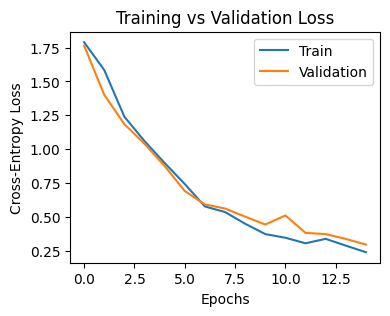

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training vs Validation Loss')
plt.show()

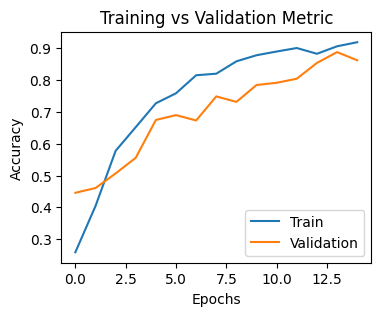

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Metric')
plt.show()

### ***Моделювання з конспекту***

***Створимо датасет, який буде репрезентувати наші дані.***

In [ ]:
class SIGNSDataset(Dataset):
    def __init__(self, data_dir, transform):
        # save file names
        self.filenames = os.listdir(data_dir)
        self.filenames = [os.path.join(data_dir, f) for f in self.filenames if f.endswith('.jpg')]
        # the first character of the file name contains the class label
        self.labels = [int(filename.split('/')[-1][0]) for filename in self.filenames]
        # save the transformations (augmentations) that we will apply to the images
        self.transform = transform

    def __len__(self):
        # returns the size of the dataset
        return len(self.filenames)

    def __getitem__(self, idx):
        # open the image, apply transformations and
        # return an image with a class label
        image = Image.open(self.filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]



***Визначимо трансформації, які ми застосуємо до зображень.***

In [ ]:
train_transformer = T.Compose([
    T.Resize(64),              # resizing the image to 64x64
    T.RandomHorizontalFlip(),  # randomly flip image horizontally
    T.ToTensor()])             # transform it into a PyTorch Tensor

eval_transformer = T.Compose([
    T.Resize(64),
    T.ToTensor()])


***Створюємо об’єкти Dataset:***

In [ ]:
train_dataset = SIGNSDataset(f'{data_path}/train_signs/', train_transformer)
test_dataset = SIGNSDataset(f'{data_path}/test_signs/', eval_transformer)


# ***Клас моделі***

In [ ]:
class BaselineModel(nn.Module):

  def __init__(self, ):
    super().__init__()
    self.num_channels = 32

    # convolution base
    self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)

    # classification layers
    self.fc1 = nn.Linear(8*8*self.num_channels*4, self.num_channels*4)
    self.fc2 = nn.Linear(self.num_channels*4, 6)

  def forward(self, s):
    #                         -> batch_size x 3 x 64 x 64
    s = self.conv1(s)                  # batch_size x num_channels x 64 x 64
    s = F.relu(F.max_pool2d(s, 2))           # batch_size x num_channels x 32 x 32
    s = self.conv2(s)                  # batch_size x num_channels*2 x 32 x 32
    s = F.relu(F.max_pool2d(s, 2))           # batch_size x num_channels*2 x 16 x 16
    s = self.conv3(s)                  # batch_size x num_channels*4 x 16 x 16
    s = F.relu(F.max_pool2d(s, 2))           # batch_size x num_channels*4 x 8 x 8

    # flatten the output for each image
    s = s.view(-1, 8*8*self.num_channels*4)       # batch_size x 8*8*num_channels*4

    # apply 2 fully connected layers with dropout
    s = F.relu(self.fc1(s))               # batch_size x self.num_channels*4
    s = self.fc2(s)                   # batch_size x 6

    return F.log_softmax(s, dim=1)

### ***Тренування моделі***

In [ ]:
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else None


In [ ]:
torch.manual_seed(42)
if cuda:
    torch.cuda.manual_seed(42)


In [ ]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=32,
                              shuffle=True,
                              num_workers=4)

test_dataloader = DataLoader(test_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=1)


In [ ]:
model = BaselineModel().to(device)


In [ ]:
model

BaselineModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


***Тренування моделі. Продовження***

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss().to(device)


In [ ]:
train_losses = []
train_accs = []

test_losses = []
test_accs = []

num_epochs = 15


In [ ]:
# Дослідити додатково!!!!!


for epoch in tqdm(range(num_epochs)):

  # Train step

  model.train()

  train_epoch_loss = []
  train_epoch_acc = []

  for i, (train_batch, labels_batch) in tqdm(enumerate(train_dataloader)):
    if cuda:
		    # non_blocking=True enables asynchronous data transfer to reduce runtime
		    train_batch, labels_batch = train_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)

    # compute model output and loss
    output_batch = model(train_batch)

    loss = criterion(output_batch, labels_batch)

    # clear previous gradients, compute gradients of all variables wrt loss
    optimizer.zero_grad()
    loss.backward()

    # performs updates using calculated gradients
    optimizer.step()

    batch_loss = loss.cpu().detach().numpy()
    batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                      labels_batch.cpu().detach().numpy())

    train_epoch_loss.append(batch_loss)
    train_epoch_acc.append(batch_acc)


  print(f'Train epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(train_epoch_loss):.4f}, Acc: {np.mean(train_epoch_acc)}')
  train_accs.append(np.mean(train_epoch_acc))
  train_losses.append(np.mean(train_epoch_loss))

  # Eval step

  model.eval()

  test_epoch_loss = []
  test_epoch_acc = []

  with torch.no_grad():

    for i, (test_batch, labels_batch) in enumerate(test_dataloader):
      if cuda:
        test_batch, labels_batch = test_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)

      # compute model output and loss
      output_batch = model(test_batch)

      loss = criterion(output_batch, labels_batch)

      batch_loss = loss.cpu().detach().numpy()
      batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                        labels_batch.cpu().detach().numpy())

      test_epoch_loss.append(batch_loss)
      test_epoch_acc.append(batch_acc)
  print(f'Test epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(test_epoch_loss):.4f}, Acc: {np.mean(test_epoch_acc)}')
  test_accs.append(np.mean(test_epoch_acc))
  test_losses.append(np.mean(test_epoch_loss))


  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt: 

***Проаналізуємо графіки функції втрат та метрики точності.***

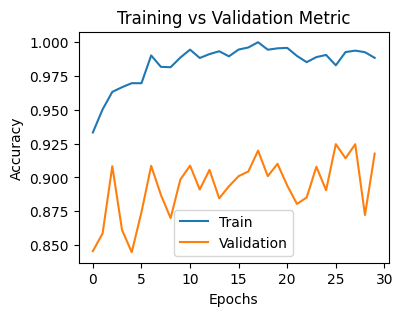

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Metric')
plt.show()

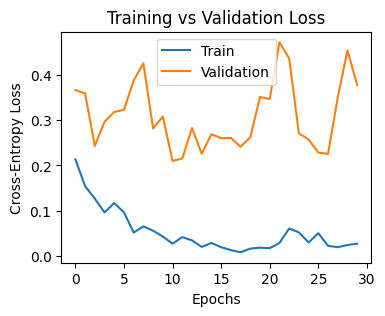

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training vs Validation Loss')
plt.show()